In [32]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier, LGBMRegressor

import econml
from econml.metalearners import SLearner, XLearner, TLearner
from econml.dml import LinearDML, CausalForestDML
from econml.dr import DRLearner

import tqdm

In [2]:
hillstrom = pd.read_csv(r'/home/robert/Documents/GMU2/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv')

In [3]:
# Map segments → treatment codes (0=control, 1=mens, 2=womens)
seg_norm = hillstrom['segment'].str.strip().str.lower()
map_dict = {
    'no e-mail': 0,
    'mens e-mail': 2,
    'womens e-mail': 1,
}
hillstrom['treatment'] = seg_norm.map(map_dict).astype('int8')

In [4]:
hillstrom.head()

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0,1
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0,1
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,2
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0,1


In [5]:
# Select the categorical columns
categorical_cols = hillstrom[['zip_code', 'channel']]

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform the categorical data
encoded_data = encoder.fit_transform(categorical_cols)

# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols.columns))

encoded_df.head()

,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,1.0


In [6]:
# Concatenate with the original DataFrame (excluding the original categorical column)
hillstrom_clean = pd.concat([hillstrom.drop(columns=['zip_code', 'channel', 'history_segment', 'segment']), encoded_df], axis=1)

In [7]:
hillstrom_clean.head()

,recency,history,mens,womens,newbie,visit,conversion,spend,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,0,0,0.0,1,0.0,1.0,0.0,0.0,1.0,0.0
1,6,329.08,1,1,1,0,0,0.0,0,1.0,0.0,0.0,0.0,0.0,1.0
2,7,180.65,0,1,1,0,0,0.0,1,0.0,1.0,0.0,0.0,0.0,1.0
3,9,675.83,1,0,1,0,0,0.0,2,1.0,0.0,0.0,0.0,0.0,1.0
4,2,45.34,1,0,0,0,0,0.0,1,0.0,0.0,1.0,0.0,0.0,1.0


In [8]:
'''
with open (r'/home/robert/Documents/GMU2/hillstrom_clean_label_mapping.json',
           'r') as f:
    hillstrom_clean_label_mapping = json.load(f)
'''

"\nwith open (r'/home/robert/Documents/GMU2/hillstrom_clean_label_mapping.json',\n           'r') as f:\n    hillstrom_clean_label_mapping = json.load(f)\n"

In [9]:
hillstrom_clean = hillstrom_clean.drop(['zip_code_Urban', 'channel_Web'], axis=1)

In [10]:
hillstrom_X = hillstrom_clean.drop(['visit', 'conversion', 'spend', 'treatment'], axis=1)
hillstrom_Y = hillstrom_clean['spend']
hillstrom_T = hillstrom_clean['treatment']

In [11]:
sample_size = hillstrom_clean.shape[0]
hillstrom_T.value_counts() / sample_size

treatment
1    0.334172
2    0.332922
0    0.332906
Name: count, dtype: float64

In [12]:
X_train_eda, X_test_eda, T_train_eda, T_test_eda = train_test_split(
    hillstrom_X,
    hillstrom_T,
    test_size=.5
)

In [13]:
T_test_eda.value_counts() / T_test_eda.shape[0]

treatment
1    0.336719
2    0.334594
0    0.328688
Name: count, dtype: float64

In [14]:
lgbm_eda = LGBMClassifier(force_col_wise=True,
                          verbosity=-1)
lgbm_eda.fit(X_train_eda, T_train_eda)

LGBMClassifier(force_col_wise=True, verbosity=-1)

In [15]:
T_pred_eda = lgbm_eda.predict(X_test_eda)
acc_eda = accuracy_score(T_test_eda, T_pred_eda)
acc_eda

0.33290625

In [16]:
'''
random_scores = []

test_eda_sample_size = T_test_eda.shape[0]

for i in range(10000):
    random_scores.append(
        (np.random.choice(
            [0, 1, 2],
            test_eda_sample_size == np.random.choice(
                [0, 1, 2],
                test_eda_sample_size)).mean())
    )
np.quantile(random_scores, .025), np.quantile(random_scores, .975)
'''

'\nrandom_scores = []\n\ntest_eda_sample_size = T_test_eda.shape[0]\n\nfor i in range(10000):\n    random_scores.append(\n        (np.random.choice(\n            [0, 1, 2],\n            test_eda_sample_size == np.random.choice(\n                [0, 1, 2],\n                test_eda_sample_size)).mean())\n    )\nnp.quantile(random_scores, .025), np.quantile(random_scores, .975)\n'

In [17]:
# use either legacy RNG...
np.random.seed(123)
# ...or the new Generator:
# rng = np.random.default_rng(123)

n = T_test_eda.shape[0]
random_scores = []

for _ in range(10_000):
    r1 = np.random.choice([0, 1, 2], size=n)          # or: rng.choice([0,1,2], size=n)
    r2 = np.random.choice([0, 1, 2], size=n)          # or: rng.choice([0,1,2], size=n)
    random_scores.append((r1 == r2).mean())

q025, q975 = np.quantile(random_scores, [0.025, 0.975])
print(q025, q975)


0.32818671875 0.3384375


In [18]:
rng = np.random.default_rng(123)
n = T_test_eda.shape[0]

r1 = rng.integers(0, 3, size=(10_000, n))
r2 = rng.integers(0, 3, size=(10_000, n))
scores = (r1 == r2).mean(axis=1)

np.quantile(scores, [0.025, 0.975])

array([0.32815625, 0.3384375 ])

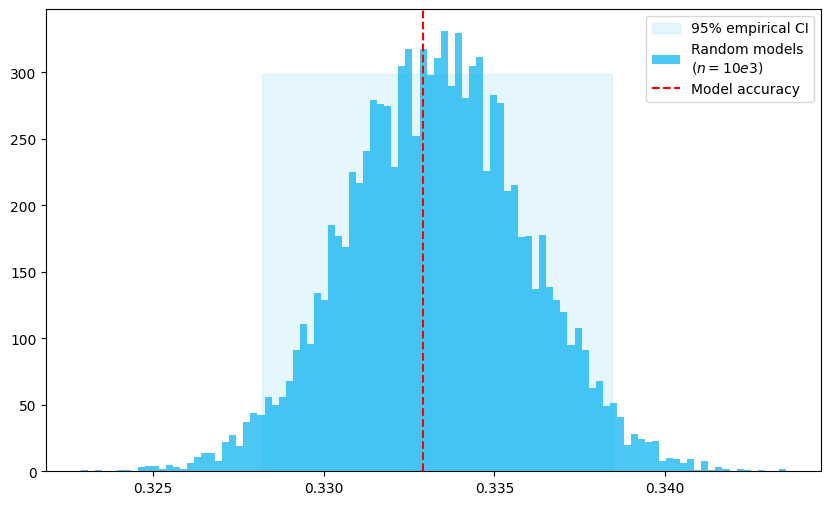

In [19]:
lower = np.quantile(random_scores, .025)
upper = np.quantile(random_scores, .975)

COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]

plt.figure(figsize=(10, 6))
plt.fill_betweenx(
    x1=lower,
    x2=upper,
    y=np.arange(0, 300),
    color=COLORS[0],
    alpha=.1,
    label='95% empirical CI'
)
plt.hist(random_scores, alpha=.7, color=COLORS[0], bins=100, label='Random models\n($n=10e3$)')
plt.axvline(acc_eda, color=COLORS[1], ls='--', label='Model accuracy')

plt.legend()
plt.show()

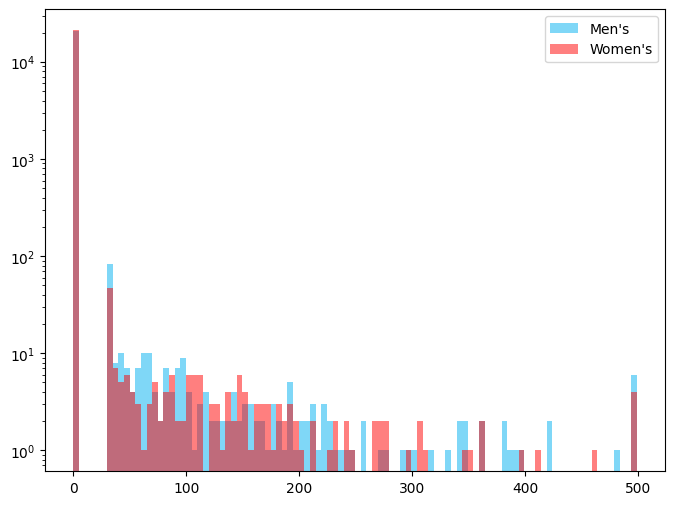

In [20]:
plt.figure(figsize=(8, 6))

plt.hist(
    hillstrom_clean[hillstrom_clean['treatment'] == 2]['spend'], 
    label=f'Men\'s', 
    color=COLORS[0],
    bins=100, 
    alpha=.5)

plt.hist(
    hillstrom_clean[hillstrom_clean['treatment'] == 1]['spend'], 
    label=f'Women\'s',
    color=COLORS[1],
    bins=100, 
    alpha=.5)

plt.legend()
plt.yscale('log')
plt.show()

In [21]:
(hillstrom_Y[hillstrom_T > 0] > 0).sum()

456

In [22]:
def create_model(model_type, n_estimators=100, max_depth=10, learning_rate=.01):
    if model_type == 'regressor':
        return LGBMRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            force_col_wise=True,
            verbosity=-1)
    elif model_type == 'classifier':
        return LGBMClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            force_col_wise=True,
            verbosity=-1)
    else:
        raise NotImplementedError(
            f'Model type `{model_type}` not implemented.')

In [23]:
s_learner = SLearner(
    overall_model=create_model('regressor')
)
################################################
x_learner = XLearner(
    models=[
        create_model('regressor'),
        create_model('regressor'),
        create_model('regressor'),
    ],
    cate_models=[
        create_model('regressor'),
        create_model('regressor'),
        create_model('regressor'),
    ]
)
###############################################
t_learner = TLearner(
    models=[
        create_model('regressor'),
        create_model('regressor'),
        create_model('regressor'),
    ]
)
###############################################
dml = LinearDML(
    model_y=create_model('regressor'),
    model_t=create_model('classifier'),
    discrete_treatment=True,
    cv=5,
)
###############################################
dr = DRLearner(
    model_propensity=LogisticRegression(),
    model_regression=create_model('regressor'),
    model_final=create_model('regressor'),
    cv=5,
)
###############################################
cf = CausalForestDML(
    model_y=create_model('regressor'),
    model_t=create_model('classifier'),
    discrete_treatment=True,
    cv=5
)

In [24]:
X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(
    hillstrom_X,
    hillstrom_Y,
    hillstrom_T,
    test_size=.5
)

In [25]:
print((y_train[T_train > 0] > 0).sum(),
(y_test[T_test > 0] > 0).sum())

219 237


In [26]:
import warnings, re
warnings.filterwarnings("ignore")

In [27]:
models = {
    'SLearner': s_learner,
    'TLearner': t_learner,
    'XLearner': x_learner,
    'DRLearner': dr,
    'LinearDML': dml,
    'CausalForestDML': cf
}

for model_name, model in models.items():
    start = time.time()
    model.fit(
        Y=y_train,
        T=T_train,
        X=X_train,
        inference='bootstrap'
    )
    stop = time.time()
    print(f'{model_name} fitted in {stop - start:0.4f} seconds.')

SLearner fitted in 20.0086 seconds.
TLearner fitted in 52.4060 seconds.
XLearner fitted in 495.1367 seconds.
DRLearner fitted in 650.8122 seconds.
LinearDML fitted in 453.5936 seconds.
CausalForestDML fitted in 740.9229 seconds.


In [35]:
# Compute effects
effects_train = {
    'treatment_1': {},
    'treatment_2': {}
}

effects_test = {
    'treatment_1': {},
    'treatment_2': {}
}


for treatment in [1, 2]:
    for model_name, model in tqdm.tqdm(models.items()):
        
        # Compute effects on train
        effects_local_train = models[model_name].effect(X_train.values, T0=0, T1=treatment)
        effects_train[f'treatment_{treatment}'][model_name] = effects_local_train
        
        # Compute effects on test
        effects_local_test = models[model_name].effect(X_test.values, T0=0, T1=treatment)
        effects_test[f'treatment_{treatment}'][model_name] = effects_local_test

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.86it/s]


In [36]:
'''
def get_uplift_by_decile(uplifts, t_true, t_pred, y_true):
    
    # Encapsulate the data & sort according to uplifts
    all_data = pd.DataFrame(
        dict(
            uplifts=uplifts, 
            y_true=y_true, 
            t_true=t_true)
    ).query(f't_true==0 | t_true=={t_pred}').sort_values('uplifts')
    
    # Partition into deciles
    all_data['deciles'] = pd.qcut(all_data['uplifts'], q=10, labels=np.arange(10), duplicates='raise')
    
    # Get mean responses within deciles
    mean_decile_resp = all_data.groupby(['deciles', 't_true']).mean()
    
    # Compute true decile uplift
    mean_decile_resp['true_uplift'] = mean_decile_resp['y_true'] * np.array([-1, 1]*10)
    true_uplift = mean_decile_resp.groupby(level=[0]).sum()['true_uplift']
    return true_uplift[::-1]
'''

In [38]:
def get_uplift_by_decile(uplifts, t_true, t_pred, y_true, k=10):
    """
    Returns a length-k array of decile uplifts, ordered from highest uplift (left) to lowest (right).
    Works even when many uplift scores are tied.
    """
    df = pd.DataFrame({
        "uplift": uplifts,
        "y": y_true,
        "t": t_true
    }).query(f"t==0 | t=={t_pred}")

    # Break ties deterministically via ranks, then cut percentiles
    r = df["uplift"].rank(method="first", pct=True)
    df["decile"] = pd.cut(r, bins=np.linspace(0, 1, k+1),
                          labels=range(k), include_lowest=True, ordered=True)

    # mean outcome per arm and decile
    m = df.groupby(["decile", "t"])["y"].mean().unstack(fill_value=np.nan)

    # ensure both arms exist as columns
    for col in [0, t_pred]:
        if col not in m.columns:
            m[col] = np.nan
    m = m[[0, t_pred]]

    # uplift per decile
    u = (m[t_pred] - m[0])

    # reindex to guarantee exactly k bins, then sort by model score so left bar = highest uplift
    u = u.reindex(range(k))
    return u.iloc[::-1].to_numpy()


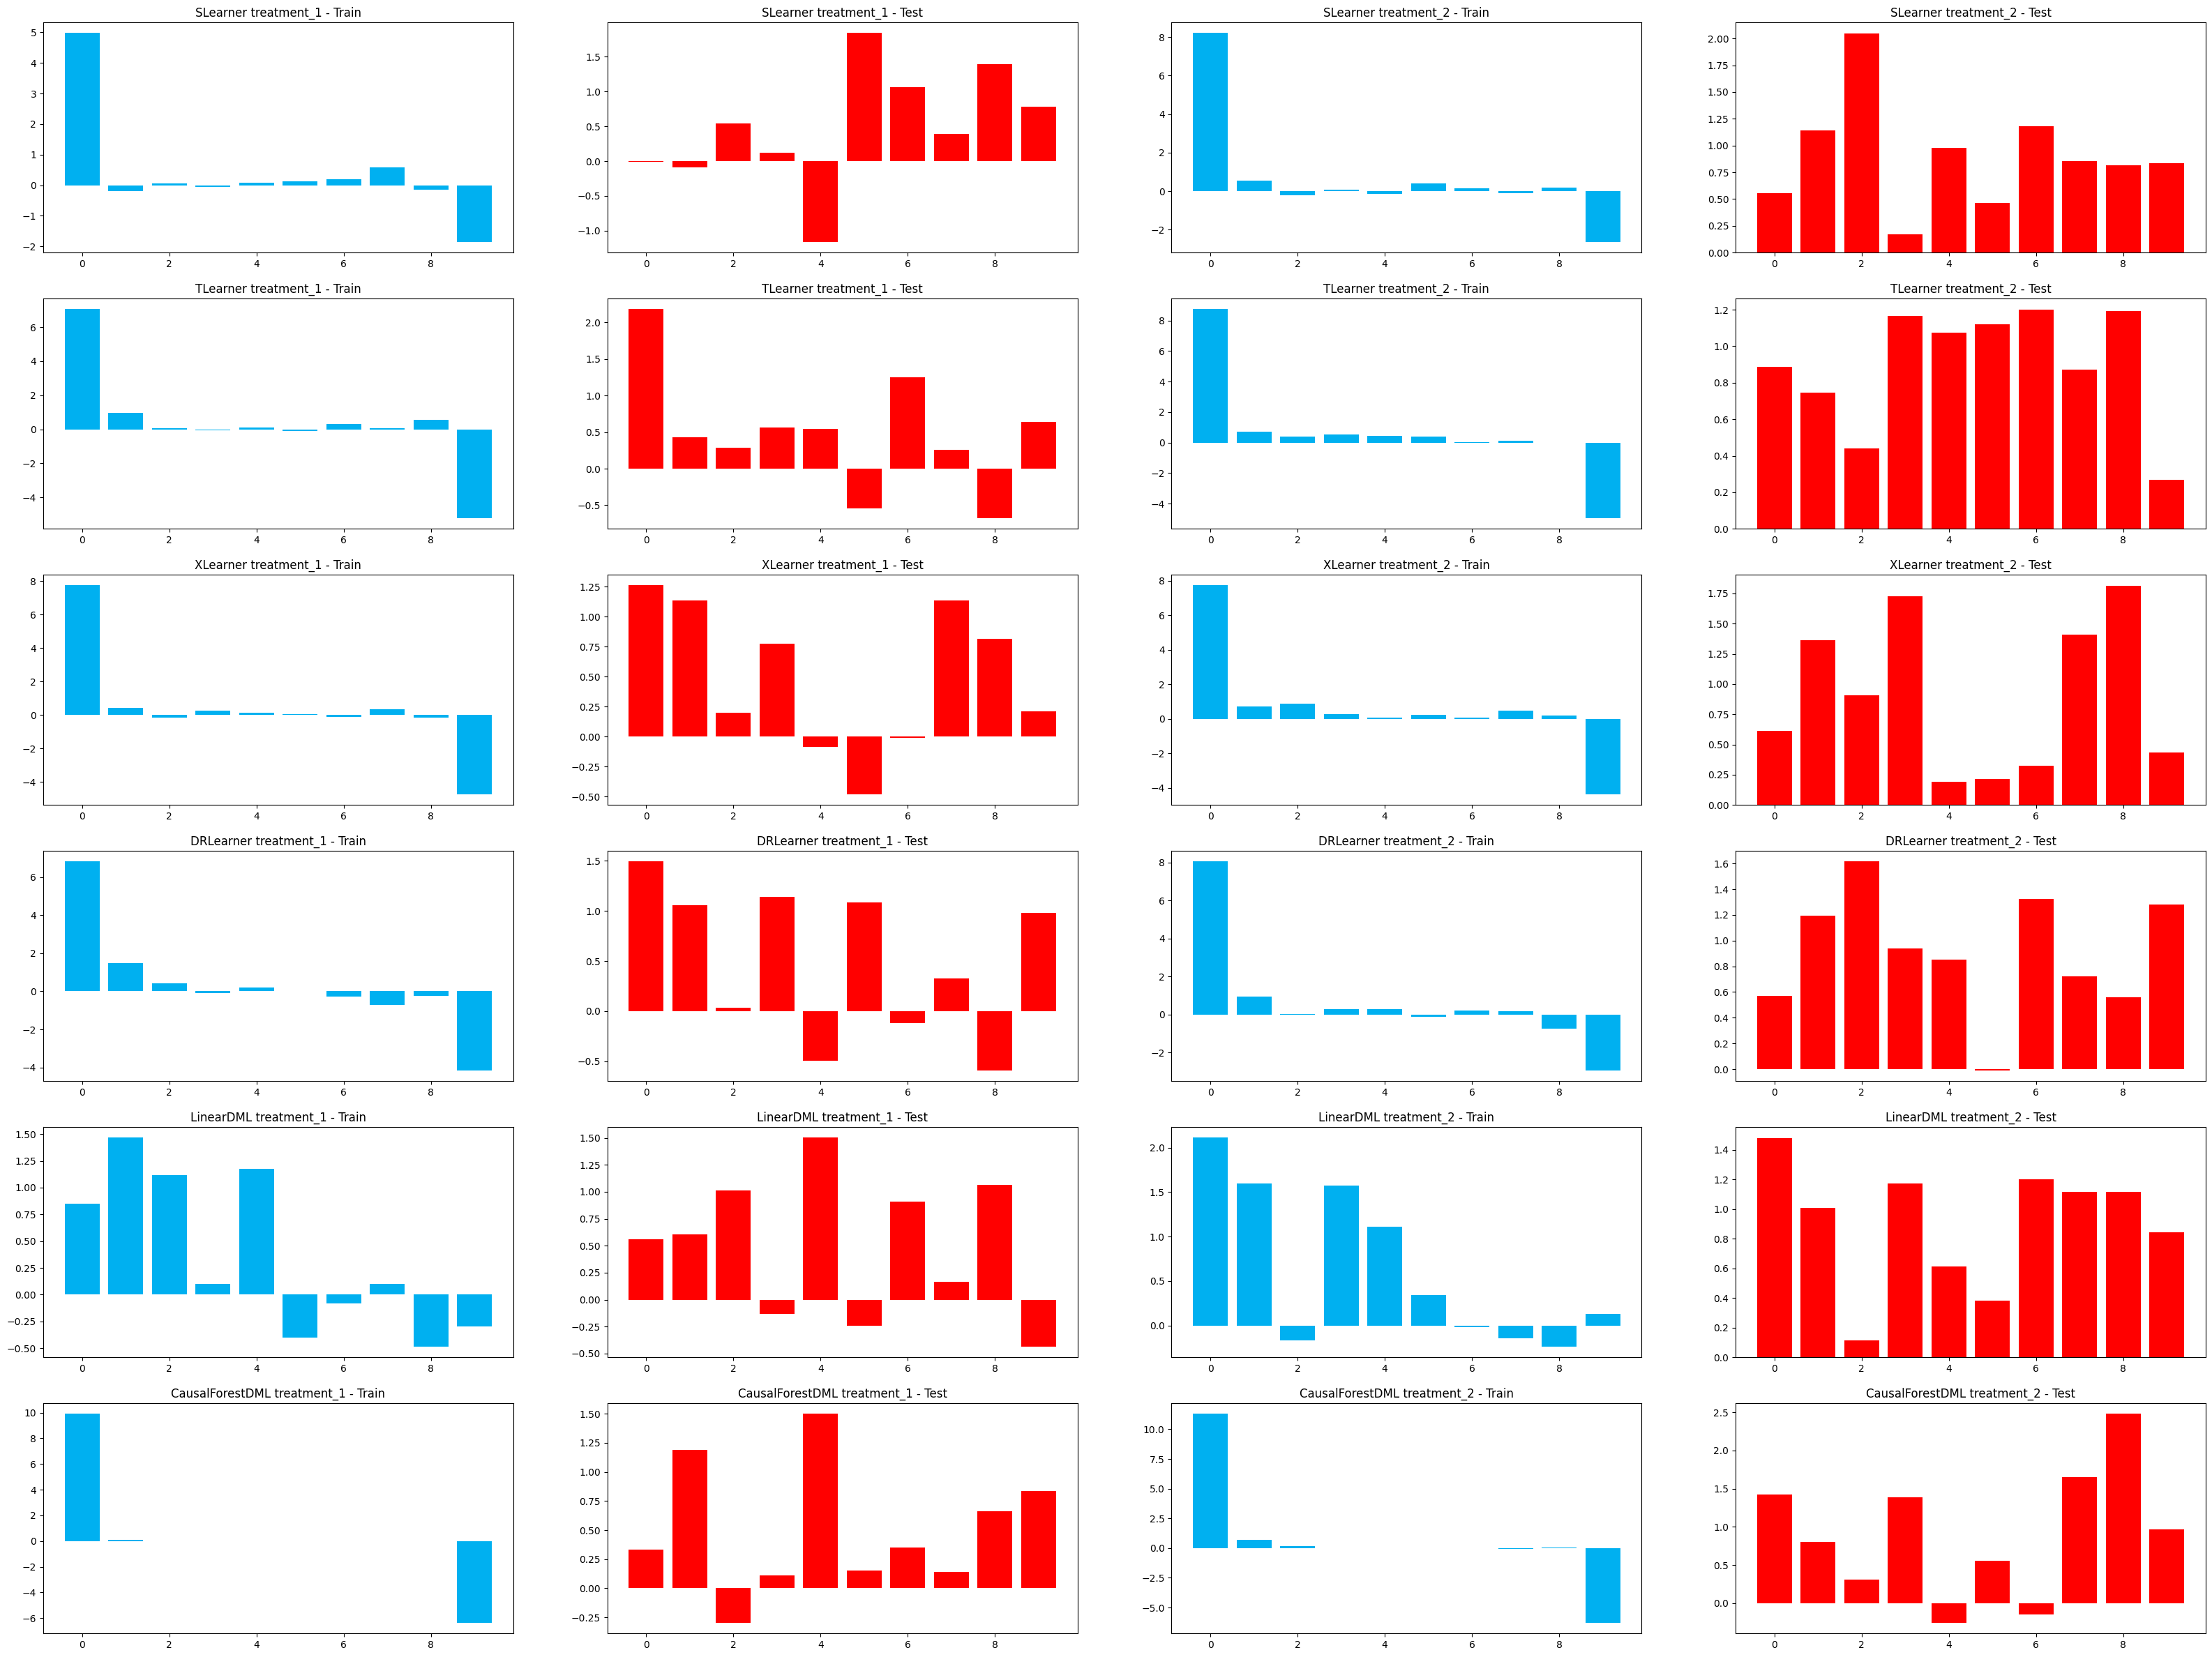

In [39]:
plt.figure(figsize=(40, 30))

i = 1

for model_name in models.keys():
    
    uplifts_by_decile = {
        'treatment_1': {},
        'treatment_2': {}
    }
    
    global_min = np.inf
    global_max = -np.inf
    
    for treatment in ['treatment_1', 'treatment_2']:

        uplift_by_decile_train = get_uplift_by_decile(
            uplifts=effects_train[treatment][model_name], 
            t_true=T_train,
            t_pred=int(treatment.split('_')[-1]),
            y_true=y_train
        )

        uplift_by_decile_test = get_uplift_by_decile(
            uplifts=effects_test[treatment][model_name], 
            t_true=T_test,
            t_pred=int(treatment.split('_')[-1]),
            y_true=y_test
        )
            
        plt.subplot(6, 4, i)
        plt.bar(np.arange(10), uplift_by_decile_train, color=COLORS[0])
        plt.title(f'{model_name} {treatment} - Train')
        
        plt.subplot(6, 4, i + 1)
        plt.bar(np.arange(10), uplift_by_decile_test, color=COLORS[1])
        plt.title(f'{model_name} {treatment} - Test')
        
        i += 2
        
plt.show()

Expected response formula:  
$$
Z=\sum_{t=0}^{K} \frac{1}{\Pr(T=t)}\, y \,\mathbb{1}\{h(x)=t\}\,\mathbb{1}\{T=t\}
$$
$K$ is the number of treatment levels  
$\mathbb{1}$ is an indicator function  
$h(x)$ is the treatment recommended by the model (treatment leading to the highest uplift
)

In [46]:
def get_effects_argmax(effects_arrays, return_matrix=False):
    """Returns argmax for each row of predicted effects for the arbitrary no. of treatments.
    
    :param effects_arrays: A list of arrays for K treatments, where K>=1 (without control null effects)
    :type effects_arrays: list of np.arrays
    
    :param return_matrix: Determines if the function returns a matrix of all effects 
        (with added null effect for control)
    :type return_matrix: bool

    ...
    :return: A stacked matrix of all effects with added column for control effects (which is always 0)
    :rtype: np.array
    """
    
    n_rows = effects_arrays[0].shape[0]
    null_effect_array = np.zeros(n_rows)
    stacked = np.stack([null_effect_array] + effects_arrays).T
    
    if return_matrix:
        return np.argmax(stacked, axis=1), stacked
    
    return np.argmax(stacked, axis=1)


def get_expected_response(y_true, t_true, effects_argmax):
    """Computes the average expected response for an uplift model according to the formula
        proposed by: 
        Zhao, Y., Fang, X., & Simchi-Levi, D. (2017). Uplift Modeling with Multiple Treatments and General Response Types. 
        Proceedings of the 2017 SIAM International Conference on Data Mining, 588-596. 
        Society for Industrial and Applied Mathematics.   
    """
    
    proba_t = pd.Series(t_true).value_counts() / np.array(t_true).shape[0]
    treatments = proba_t.index.values
    
    z_vals = 0
    
    for treatment in treatments:
        h_indicator = effects_argmax == treatment
        t_indicator = t_true == treatment
        t_proba_local = proba_t[treatment]
        
        z_vals += (1/t_proba_local) * y_true * h_indicator * t_indicator
    
    return z_vals.mean()

In [48]:
# Compute expected response
print('Expeceted response on train:\n')
for model_name in models:
    effects_argmax = get_effects_argmax(
        [
            effects_train['treatment_1'][model_name],
            effects_train['treatment_2'][model_name]
        ]
    )
    
    expected_response = get_expected_response(
        y_true=y_train, 
        t_true=T_train, 
        effects_argmax=effects_argmax
    )
    
    print(f'{model_name}: {expected_response}')
    
print('\n' + '-'*30)
    
print('Expected response on test:\n')
for model_name in models:
    effects_argmax = get_effects_argmax(
        [
            effects_test['treatment_1'][model_name],
            effects_test['treatment_2'][model_name]
        ]
    )
    
    expected_response = get_expected_response(
        y_true=y_test, 
        t_true=T_test, 
        effects_argmax=effects_argmax
    )
    
    print(f'{model_name}: {expected_response}')

Expecetd response on train:

SLearner: 2.019492101790634
TLearner: 2.4403060823313
XLearner: 2.3084720059890977
DRLearner: 2.1798652682767097
LinearDML: 1.5087123575237131
CausalForestDML: 2.810673917146105

------------------------------
Expected response on test:

SLearner: 1.199982340410465
TLearner: 1.3907954979226873
XLearner: 1.41453463482093
DRLearner: 1.409775248412886
LinearDML: 1.353608340276406
CausalForestDML: 1.1324545100892054


In [42]:
# Outcome in the whole dataset
hillstrom_clean.groupby('treatment')['spend'].mean()

treatment
0    0.652789
1    1.077202
2    1.422617
Name: spend, dtype: float64

In [45]:
models['LinearDML'].effect_interval(X=X_test, T0=0, T1=1)

(array([-0.35705805, -1.08547578, -0.05098616, ...,  0.0304347 ,
        -0.30889248, -0.74708222]),
 array([1.38861642, 0.99640204, 1.94987854, ..., 2.27285005, 1.85524756,
        2.25195997]))

In [49]:
models['LinearDML'].effect_interval(X=X_test.iloc[0:1, :], T0=0, T1=1)

(array([-0.35705805]), array([1.38861642]))

In [50]:
# CIs (DML)
ints = np.stack(models['LinearDML'].effect_interval(X=X_test, T0=0, T1=1, alpha=.05)).T

# What % of effects contains zero?
(np.sign(ints[:, 0]) == np.sign(ints[:, 1])).sum() / ints.shape[0]

0.1015